# V2X 데이터 정보

In [1]:
import numpy as np
import cv2
import torch
import pandas as pd
import re
import pickle as pkl
import json
import glob
import shutil
import os
import json
import pathlib as pl
from typing import List, Tuple, Dict, Union, Optional
from tqdm import trange, tqdm
from glob import glob
from collections import Counter
from sklearn.model_selection import train_test_split

from preprocessing import V2XPreprocessing
from modules.v2x import V2XData,V2XDataLabeled
from tsai.all import *
from tqdm import tqdm
from modules.RunTSAI import RunTSAI
from sklearn.utils import shuffle

data_path_8 = "/data/NIA50/50-1/data/v2xfinal/8월"
data_path_8s = "/data/NIA50/50-1/data/v2xfinal/8월세종"
data_path_10 = "/data/NIA50/50-1/data/v2xfinal/9월"
data_path_10 = "/data/NIA50/50-1/data/v2xfinal/10월"
data_path_11 = "/data/NIA50/50-1/data/v2xfinal/11월"

## CSV, JSON 파일 경로 리스트 만들기
- CSV, JSON 파일을 한 경로에 담기
  - 8월
  -  ㄴ CSV
  -  ㄴ JSON
  - 9월
  -  ㄴ CSV
  -  ㄴ JSON

In [2]:
# 10월csv파일과 json파일을 각각 리스트로 가져옴
csv_files10, json_files10 = V2XPreprocessing.get_csv_data(data_path_10 + "/CSV"), \
                            V2XPreprocessing.get_json_data(data_path_10 + "/JSON")
print(f"csv file count: {len(csv_files10)}, json file count: {len(json_files10)}")

csv file count: 1350000, json file count: 1350000


In [3]:
# csv파일과 json파일 리스트를 pickle로 저장
with open("pickles/10월/CSV10.pkl", "wb") as f:
    pkl.dump(csv_files10, f)
with open("pickles/10월/JSON10.pkl", "wb") as f:
    pkl.dump(json_files10, f)

In [2]:
# csv파일과 json파일 각 리스트를 pickle로 가져옴
with open("pickles/10월/CSV10.pkl", "rb") as f:
    csv_files10 = pkl.load(f)
with open("pickles/10월/JSON10.pkl", "rb") as f:
    json_files10 = pkl.load(f)

In [9]:
no_error, y_error = [], []
for csv in csv_files10:
    try:
        pd.read_csv(csv)
        no_error.append(csv)
    except Exception as e:
        print(f"{csv} error: {e}")
        y_error.append(csv)
    

/data/NIA50/50-1/data/v2xfinal/10월/CSV/221004/C/A/FFE81185/V_221004_C_A_FFE81185_000030.csv error: No columns to parse from file


In [ ]:
# CSV파일 concat, pickle로 저장
try:
    df10csv = [pd.read_csv(f) for f in tqdm(csv_files10, desc="Reading csv files")]
except pd.errors.EmptyDataError as e:
    print(f"EmptyDataError: {e}")
    print(f"csv file: {f}")

df10csv = pd.concat(df10csv, ignore_index=True)
with open("pickles/10월/df10csv.pkl", "wb") as f:
    pkl.dump(df10csv, f)

In [16]:
# CSV파일 concat pickle로 가져옴
with open("pickles/10월/df10csv.pkl", "rb") as f:
    df10csv = pkl.load(f)

In [17]:
df10csv.head()

,ISSUE_DATE,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,20221001130540,FFE809A6,9228,126.908813,35.164802,100,0,80,0,bus
1,20221001130541,FFE809A6,9228,126.908813,35.164802,100,0,80,0,bus
2,20221001130542,FFE809A6,9228,126.908813,35.164802,100,0,80,0,bus
3,20221001130543,FFE809A6,9228,126.908813,35.164802,100,0,80,0,bus
4,20221001130544,FFE809A6,9228,126.908812,35.164802,100,0,80,0,bus


In [19]:
print(df10csv.isna().sum())
# NaN값 제거 후 NaN값이 있는지 확인
df10csv = df10csv.dropna()
# counts rows if there's NaN value
# df10csv.isna().sum()

df10csv.shape

ISSUE_DATE       0
VEHICLE_ID       0
VEHICLE_CLASS    0
LONGITUDE        0
LATITUDE         0
HEADING          0
SPEED            0
BRAKE_STATUS     0
ACC_SEC          0
VEHICLE_TYPE     0
dtype: int64


(13500000, 10)

In [20]:
df10csv.head()

,ISSUE_DATE,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,20221001130540,FFE809A6,9228,126.908813,35.164802,100,0,80,0,bus
1,20221001130541,FFE809A6,9228,126.908813,35.164802,100,0,80,0,bus
2,20221001130542,FFE809A6,9228,126.908813,35.164802,100,0,80,0,bus
3,20221001130543,FFE809A6,9228,126.908813,35.164802,100,0,80,0,bus
4,20221001130544,FFE809A6,9228,126.908812,35.164802,100,0,80,0,bus


In [27]:
# int or float type이 아닌 값이 있는지 확인
for col in df10csv.columns:
    if col in ["ISSUE_DATE"]:
        df10csv.drop(col, axis=1, inplace=True)
        continue
    if col in ["VEHICLE_ID", "VEHICLE_TYPE"]:
        continue
    # print if value is not float or int
    print(f"{col}: {df10csv[col].apply(lambda x: type(x) not in [float, int]).sum()}")

VEHICLE_CLASS: 0
LONGITUDE: 0
LATITUDE: 0
HEADING: 0
SPEED: 0
BRAKE_STATUS: 0
ACC_SEC: 0


In [22]:
# exclude ["ISSUE_DATE"] column, values to int on ["VEHICLE_CLASS", "HEADING"], str on ["VEHICLE_ID", "VEHICLE_TYPE"], float on others

for col in df10csv.columns:
    if col in ["VEHICLE_CLASS", "HEADING"]:
        df10csv[col] = df10csv[col].astype(int)
    elif col in ["VEHICLE_ID", "VEHICLE_TYPE"]:
        df10csv[col] = df10csv[col].astype(str)
    else:
        df10csv[col] = df10csv[col].astype(float)

In [23]:
# value counts of VEHICLE_ID VEHICLE_CLASS VEHICLE_TYPE
for col in df10csv.columns:
    if col in ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"]:
        print(f"{col}: {df10csv[col].value_counts()}")
        print(f"{col} unique: {df10csv[col].unique().shape}", end="\n\n")

VEHICLE_ID: FFE80CCB    20400
FFE80A16    20200
FFE80DFE    18600
FFE80D0E    17600
FFE80AE0    16800
            ...  
FFE81035      200
FFE80FA7      200
FFE8113F      200
FFE811E6      200
FFE80E4D      200
Name: VEHICLE_ID, Length: 1657, dtype: int64
VEHICLE_ID unique: (1657,)

VEHICLE_CLASS: 9228    10204600
9220     2971200
9741      114400
9736       91800
9230       84200
9240       25600
9734        8000
9227         200
Name: VEHICLE_CLASS, dtype: int64
VEHICLE_CLASS unique: (8,)

VEHICLE_TYPE: bus         10203732
car          2970852
special       323965
none            1251
axleCnt2         200
Name: VEHICLE_TYPE, dtype: int64
VEHICLE_TYPE unique: (5,)



In [24]:
# categorize ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"] columns
from sklearn.preprocessing import LabelEncoder

for col in df10csv.columns:
    if col in ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"]:
        encoder = LabelEncoder()
        encoder.fit(df10csv[col])
        categorized_array = encoder.transform(df10csv[col])
        print(categorized_array)
        df10csv[col] = categorized_array

[  10   10   10 ... 1656 1656 1656]
[2 2 2 ... 2 2 2]
[1 1 1 ... 1 1 1]


In [28]:
# index reset
df10csv.reset_index(drop=True, inplace=True)
df10csv

,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,10,2,126.908813,35.164802,100,0.0,80.0,0.0,1
1,10,2,126.908813,35.164802,100,0.0,80.0,0.0,1
2,10,2,126.908813,35.164802,100,0.0,80.0,0.0,1
3,10,2,126.908813,35.164802,100,0.0,80.0,0.0,1
4,10,2,126.908812,35.164802,100,0.0,80.0,0.0,1
...,...,...,...,...,...,...,...,...,...
13499995,1656,2,126.923304,35.177653,286,19.0,78.0,0.0,1
13499996,1656,2,126.923247,35.177668,286,20.0,78.0,28.0,1
13499997,1656,2,126.923190,35.177683,288,19.0,78.0,0.0,1
13499998,1656,2,126.923133,35.177698,287,19.0,78.0,0.0,1


# Standarization

In [29]:
# standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df10csv_scaled = scaler.fit_transform(df10csv)
df10csv_scaled = pd.DataFrame(df10csv_scaled, columns=df10csv.columns)
df10csv_scaled

,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,-1.550605,0.343457,0.048559,0.015181,-0.618204,-0.817212,1.127367,-0.002755,-0.493227
1,-1.550605,0.343457,0.048559,0.015181,-0.618204,-0.817212,1.127367,-0.002755,-0.493227
2,-1.550605,0.343457,0.048559,0.015181,-0.618204,-0.817212,1.127367,-0.002755,-0.493227
3,-1.550605,0.343457,0.048558,0.015179,-0.618204,-0.817212,1.127367,-0.002755,-0.493227
4,-1.550605,0.343457,0.048558,0.015179,-0.618204,-0.817212,1.127367,-0.002755,-0.493227
...,...,...,...,...,...,...,...,...,...
13499995,2.127606,0.343457,0.065006,0.117304,1.087438,0.154325,1.076380,-0.002755,-0.493227
13499996,2.127606,0.343457,0.064941,0.117426,1.087438,0.205458,1.076380,0.555061,-0.493227
13499997,2.127606,0.343457,0.064876,0.117546,1.105778,0.154325,1.076380,-0.002755,-0.493227
13499998,2.127606,0.343457,0.064812,0.117665,1.096608,0.154325,1.076380,-0.002755,-0.493227


# CSV 파일 Dataframe pickle로 저장

In [31]:
with open("pickles/10월/df10_scaled.pkl", "wb") as f:
    pkl.dump(df10csv_scaled, f)

# # save csv file
# df10csv_scaled.to_csv("pickles/10월/df10_scaled.csv", index=False)

In [32]:
df10csv_scaled = pd.read_pickle("pickles/10월/df10_scaled.pkl") # load scaled csv file

In [33]:
# reshape 1350000 rows × 9 columns to 1350000 rows x 9 columns x 10, and changed to numpy array
df10csv_scaled_npy = df10csv_scaled.values.reshape(df10csv_scaled.shape[0]//10, 10, 9)
df10csv_scaled_npy = df10csv_scaled_npy.transpose(0, 2, 1)

In [34]:
# save numpy array as npy file
np.save("pickles/10월/X_10.npy", df10csv_scaled_npy)

In [35]:
print(df10csv_scaled_npy.shape)
df10csv_scaled_npy[:2]

(1350000, 9, 10)


array([[[-1.55060453, -1.55060453, -1.55060453, -1.55060453,
         -1.55060453, -1.55060453, -1.55060453, -1.55060453,
         -1.55060453, -1.55060453],
        [ 0.34345709,  0.34345709,  0.34345709,  0.34345709,
          0.34345709,  0.34345709,  0.34345709,  0.34345709,
          0.34345709,  0.34345709],
        [ 0.04855927,  0.04855893,  0.0485587 ,  0.04855848,
          0.04855814,  0.04855814,  0.04855791,  0.0485578 ,
          0.04855757,  0.04855757],
        [ 0.01518095,  0.01518095,  0.01518095,  0.01517936,
          0.01517856,  0.01517856,  0.01517856,  0.01517856,
          0.01517697,  0.01517697],
        [-0.61820431, -0.61820431, -0.61820431, -0.61820431,
         -0.61820431, -0.61820431, -0.61820431, -0.61820431,
         -0.61820431, -0.61820431],
        [-0.81721231, -0.81721231, -0.81721231, -0.81721231,
         -0.81721231, -0.81721231, -0.81721231, -0.81721231,
         -0.81721231, -0.81721231],
        [ 1.12736656,  1.12736656,  1.12736656,  1.1

----------------------

# JSON

In [42]:
with open("pickles/10월/JSON10.pkl", "rb") as f:
    json_files10 = pkl.load(f)

In [3]:
# json info
with open(json_files10[0], "r") as f:
    json_sample = json.load(f)
json_sample

{'Path': 'V_221001_C_A_FFE809A6_000030.csv',
 'Annotation': {'Vehicle_ID': 'FFE809A6',
  'Turn': 'False',
  'Lane': 'False',
  'Speed': 'False',
  'Hazard': 'False'}}

In [46]:
json10_list = []
cols = ['Turn', 'Lane', 'Speed', 'Hazard']
print(cols)

df8json = pd.DataFrame(columns=cols)
for i in trange(len(json_files10)):
    with open(json_files10[i], "r") as f:
        try:
            temp_json = json.load(f)
            temp_json = [temp_json['Annotation'][key][:4] for key in temp_json['Annotation'].keys() if key in cols]
            json10_list.append(temp_json)
            
        except Exception as e:
            print(f"{json_files10[i]} error: {e}")
            continue
        
# json8_list = [x[:4] for x in json8_list]
json10_npy = np.array(json10_list)
np.save("pickles/10월/y_10.npy", json10_npy)

['Turn', 'Lane', 'Speed', 'Hazard']


100%|██████████| 1350000/1350000 [28:35<00:00, 786.86it/s] 


# Time series classification

In [47]:
X = np.load("pickles/10월/X_10.npy")
y = np.load("pickles/10월/y_10.npy")

###
from collections import Counter
print("turn:", np.unique(y[:, 0]))
print("lane:", np.unique(y[:, 1]))
print("speed:", np.unique(y[:, 2]))
print("hazard:", np.unique(y[:, 3]))
print("turn:", Counter(y[:, 0]))
print("lane:", Counter(y[:, 1]))
print("speed:", Counter(y[:, 2]))
print("hazard:", Counter(y[:, 3]))

turn: ['Fals' 'Left' 'Reve' 'Righ']
lane: ['Fals']
speed: ['Acc' 'Fals' 'Hbrk']
hazard: ['Fals' 'True']
turn: Counter({'Fals': 1273760, 'Righ': 38146, 'Left': 35737, 'Reve': 2357})
lane: Counter({'Fals': 1350000})
speed: Counter({'Fals': 1348931, 'Hbrk': 800, 'Acc': 269})
hazard: Counter({'Fals': 1345491, 'True': 4509})


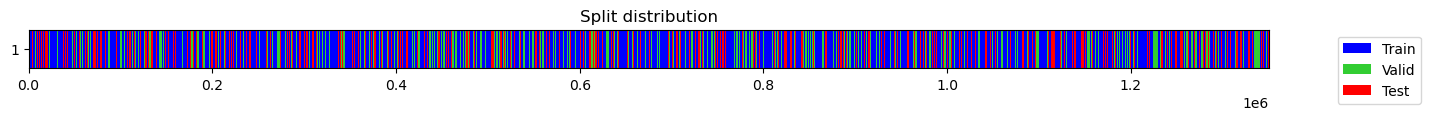

In [48]:
from tsai.all import *
config = AttrDict(
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = LSTM, # LSTM, MLSTM_Plus
    lr = 1e-3,
    n_epochs = 200,
)

X = np.load("pickles/10월/X_10.npy")
y = np.load("pickles/10월/y_10.npy")
split_all = get_splits(y[:,0], shuffle=True, valid_size=0.2, test_size=0.2, random_state=42)
split = split_all

In [49]:
X.shape, y.shape

((1350000, 9, 10), (1350000, 4))

In [50]:
test_eq(X.shape, (X.shape[0], 9, 10))
test_eq(y.shape, (X.shape[0], 4))

In [51]:
tfms = [None, [MultiCategorize, OneHotEncode]]
dsets = TSDatasets(X, y, tfms=tfms, splits=split)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], shuffle_train=False, batch_tfms=[TSStandardize()])

model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=[accuracy_multi, precision_multi, F1_multi])
learn.fit_one_cycle(10)
learn.recorder.plot_loss()

In [ ]:
learn.recorder.plot_metrics()
learn.save_all("models/V2X_10")

-------------------